# Sparse Autoencoder Feature Classifier

In [1]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb

✓ XGBoost available
PyTorch: 2.6.0+cu124
CUDA available: True


In [ ]:
import sys
sys.path.insert(0, '/home/asm/LHC-AD/Attempt 5')

from sparse_feature_extractor import (
    SparseAutoEncoder3C,
    SparseJetImageDataset3C,
    train_autoencoder,
    load_pretrained_model,
    extract_features_from_dataset,
    H5_FILE_PATH, MODEL_SAVE_PATH, DEVICE
)

print(f"\nDevice: {DEVICE}")
print(f"Data: {H5_FILE_PATH}")
print(f"Model save path: {MODEL_SAVE_PATH}")


Device: cuda
Data: /home/asm/LHC-AD/Working files/3C_jet_images_parallel.h5
Model save path: /home/asm/LHC-AD/Attempt 5/Results and wts 3/sparse_ae_3channel.pth


---
## Train/Load Sparse Autoencoder

In [ ]:
if os.path.exists(MODEL_SAVE_PATH):
    print(f"Pretrained model found: {MODEL_SAVE_PATH}")
    print("Loading pretrained model...")
    model = load_pretrained_model(MODEL_SAVE_PATH)
else:
    print("No pretrained model found. Training new model...")
    
    # Subset of training data (300k samples)
    model = train_autoencoder(max_train_samples=300000)

✓ Pretrained model found: /home/asm/LHC-AD/Attempt 5/Results and wts 3/sparse_ae_3channel.pth
Loading pretrained model...
✓ Loaded weights from: /home/asm/LHC-AD/Attempt 5/Results and wts 3/sparse_ae_3channel.pth
✓ Device: cuda
✓ Bottleneck channels: 128


---
## Feature Extraction

In [ ]:
dataset = SparseJetImageDataset3C(H5_FILE_PATH)
print(f"Total samples: {len(dataset)}")

Dataset: 1100000 samples, 3 channels
Total samples: 1100000


In [ ]:
# Extract features from the full dataset
# Set max_samples to a smaller number for quick testing
MAX_SAMPLES = None 

print("Extracting bottleneck features...")

features, labels = extract_features_from_dataset(
    model=model,
    dataset=dataset,
    batch_size=64,
    max_samples=MAX_SAMPLES
)

print(f"\nExtraction complete!")
print(f"Feature dimension: {features.shape[1]} (bottleneck channels)")

Extracting bottleneck features...
This may take a few minutes...

Extracting features from 1100000 samples (17188 batches)...
  Progress: 25% (4297/17188 batches)
  Progress: 50% (8594/17188 batches)
  Progress: 75% (12891/17188 batches)
  Progress: 100% (17188/17188 batches)
✓ Features shape: (1100000, 128)
✓ Labels: 999156 background, 99996 signal

Extraction complete!
Feature dimension: 128 (bottleneck channels)


---
## Preparing Data for Classification

In [ ]:
import h5py
with h5py.File('/home/asm/LHC-AD/Working files/3C_jet_images_parallel.h5', 'r') as f:
    print("Original labels unique:", np.unique(f['labels'][:]))

In [ ]:
# Filter to binary labels only (remove -1)
mask = labels >= 0
features = features[mask]
labels = labels[mask]

print(f"After filtering: {len(labels)} samples (removed {(~mask).sum()} with label -1)")
print(f"Unique labels: {np.unique(labels)}")

In [6]:
# Check class distribution
n_background = np.sum(labels == 0)
n_signal = np.sum(labels == 1)

print(f"Class Distribution:")
print(f"  Background (0): {n_background:,} ({100*n_background/len(labels):.2f}%)")
print(f"  Signal (1):     {n_signal:,} ({100*n_signal/len(labels):.2f}%)")
print(f"  Imbalance ratio: {n_background/n_signal:.1f}:1")

Class Distribution:
  Background (0): 999,156 (90.83%)
  Signal (1):     99,996 (9.09%)
  Imbalance ratio: 10.0:1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels.astype(int),
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print(f"Training: {len(X_train):,} samples")
print(f"Test:     {len(X_test):,} samples")

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features standardized")

Training: 879,321 samples
Test:     219,831 samples
✓ Features standardized


---
## Training Classifiers

In [ ]:
# Define classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=n_background / n_signal,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
}
print(f"Classifiers: {list(classifiers.keys())}")

Classifiers: ['Logistic Regression', 'Random Forest', 'XGBoost']


In [10]:
# Train and evaluate all classifiers
results = {}

for name, clf in classifiers.items():
    print(f"\n{'='*50}")
    print(f"Training: {name}")
    print('='*50)
    
    # Use scaled for Logistic Regression, raw for trees
    if 'Logistic' in name:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
        y_prob = clf.predict_proba(X_test_scaled)[:, 1]
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]
    
    # Metrics
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    results[name] = {
        'model': clf,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'auc': auc,
        'fpr': fpr,
        'tpr': tpr
    }
    
    print(f"\nROC AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred, target_names=['Background', 'Signal']))


Training: Logistic Regression

ROC AUC: 0.8348
              precision    recall  f1-score   support

  Background       0.96      0.80      0.88    199832
      Signal       0.26      0.70      0.38     19999

    accuracy                           0.79    219831
   macro avg       0.61      0.75      0.63    219831
weighted avg       0.90      0.79      0.83    219831


Training: Random Forest

ROC AUC: 0.8000
              precision    recall  f1-score   support

  Background       0.96      0.83      0.89    199832
      Signal       0.26      0.61      0.37     19999

    accuracy                           0.81    219831
   macro avg       0.61      0.72      0.63    219831
weighted avg       0.89      0.81      0.84    219831


Training: XGBoost

ROC AUC: 0.8362
              precision    recall  f1-score   support

  Background       0.96      0.81      0.88    199832
      Signal       0.27      0.70      0.39     19999

    accuracy                           0.80    219831
  

---
## Visualizing results

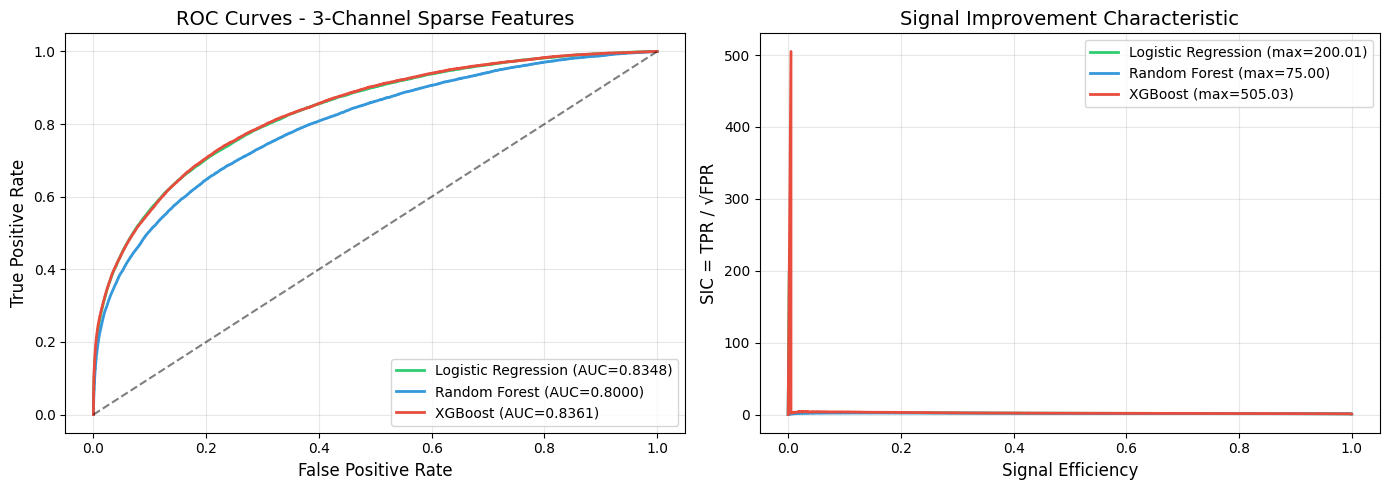

In [27]:
# ROC and SIC curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#2ecc71', '#3498db', '#e74c3c']

# ROC Curve
ax1 = axes[0]
for (name, res), color in zip(results.items(), colors):
    ax1.plot(res['fpr'], res['tpr'], 
             label=f"{name} (AUC={res['auc']:.4f})",
             color=color, linewidth=2)

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curves - 3-Channel Sparse Features', fontsize=14)
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)

# SIC Curve
ax2 = axes[1]
for (name, res), color in zip(results.items(), colors):
    fpr_safe = np.maximum(res['fpr'], 1e-10)
    sic = res['tpr'] / np.sqrt(fpr_safe)
    max_sic = np.max(sic[np.isfinite(sic)])
    ax2.plot(res['tpr'], sic, 
             label=f"{name} (max={max_sic:.2f})",
             color=color, linewidth=2)

ax2.set_xlabel('Signal Efficiency', fontsize=12)
ax2.set_ylabel('SIC = TPR / √FPR', fontsize=12)
ax2.set_title('Signal Improvement Characteristic', fontsize=14)
ax2.legend(loc='upper right')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/home/asm/LHC-AD/Attempt 5/classifier_comparison_3c.png', dpi=150)
plt.show()

In [ ]:
# Summary table
print("="*60)
print(f"{'Classifier':<25} {'ROC AUC':>10} {'Max SIC':>10}")
print("-"*60)

for name, res in results.items():
    fpr_safe = np.maximum(res['fpr'], 1e-10)
    sic = res['tpr'] / np.sqrt(fpr_safe)
    max_sic = np.max(sic[np.isfinite(sic)])
    print(f"{name:<25} {res['auc']:>10.4f} {max_sic:>10.2f}")

print("="*60)


SUMMARY: 3-Channel Sparse Feature Classifier Performance
Classifier                   ROC AUC    Max SIC
------------------------------------------------------------
Logistic Regression           0.8348     200.01
Random Forest                 0.8000      75.00
XGBoost                       0.8361     505.03


---
## Feature Importance

Best: XGBoost (AUC = 0.8361)


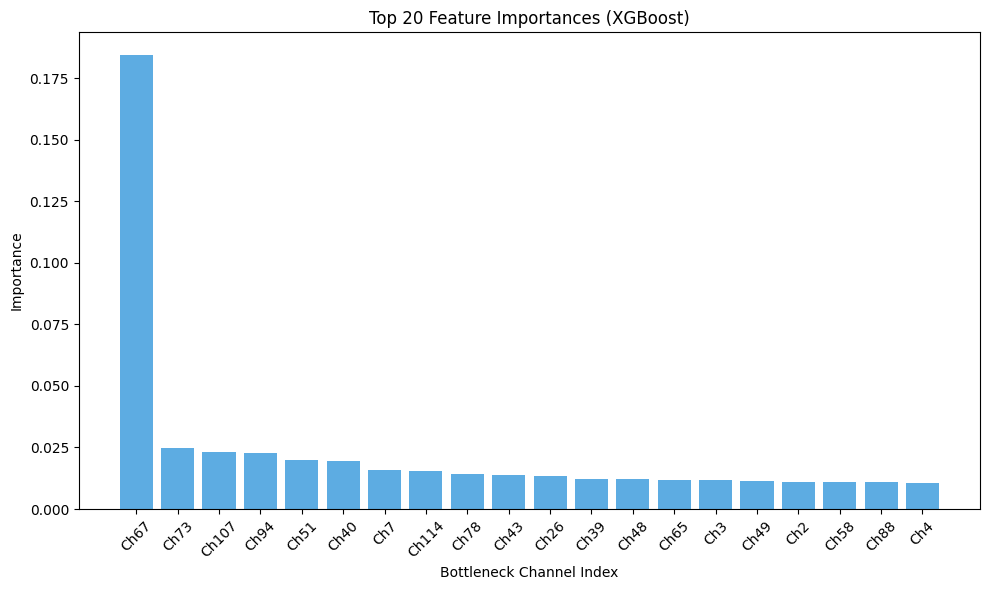


Top 5 channels: [ 67  73 107  94  51]


In [29]:
# Find best model
best_name = max(results, key=lambda x: results[x]['auc'])
best_model = results[best_name]['model']
best_auc = results[best_name]['auc']

print(f"Best: {best_name} (AUC = {best_auc:.4f})")

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    n_top = min(20, len(importances))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(range(n_top), importances[indices[:n_top]], color='#3498db', alpha=0.8)
    ax.set_xlabel('Bottleneck Channel Index')
    ax.set_ylabel('Importance')
    ax.set_title(f'Top {n_top} Feature Importances ({best_name})')
    ax.set_xticks(range(n_top))
    ax.set_xticklabels([f'Ch{indices[i]}' for i in range(n_top)], rotation=45)
    plt.tight_layout()
    plt.savefig('/home/asm/LHC-AD/Attempt 5/feature_importance_3c.png', dpi=150)
    plt.show()
    
    print(f"\nTop 5 channels: {indices[:5]}")

---
## Saving Models and Features

In [ ]:
import joblib

# Save best classifier
clf_path = f'/home/asm/LHC-AD/Attempt 5/Results and wts 1/best_classifier_{best_name.lower().replace(" ", "_")}.joblib'
joblib.dump(best_model, clf_path)
print(f"Classifier: {clf_path}")

# Save scaler
scaler_path = '/home/asm/LHC-AD/Attempt 5/Results and wts 1/feature_scaler.joblib'
joblib.dump(scaler, scaler_path)
print(f" Scaler: {scaler_path}")

# Save extracted features
features_path = '/home/asm/LHC-AD/Attempt 5/Results and wts 1/extracted_features_3c.npz'
np.savez(features_path, features=features, labels=labels)
print(f"Features: {features_path}")

✓ Classifier: /home/asm/LHC-AD/Attempt 5/best_classifier_xgboost.joblib
✓ Scaler: /home/asm/LHC-AD/Attempt 5/feature_scaler.joblib
✓ Features: /home/asm/LHC-AD/Attempt 5/extracted_features_3c.npz


---
## Checking for mass correlation and other plots

In [34]:
# Get best model predictions
best_name = max(results, key=lambda x: results[x]['auc'])
y_prob_best = results[best_name]['y_prob']

print(f"Best model: {best_name}")

Best model: XGBoost


In [ ]:
import h5py

with h5py.File('/home/asm/LHC-AD/Working files/3C_jet_images_parallel.h5', 'r') as f:
    mjj_all = f['MJJ'][:]
    labels_all = f['labels'][:]

if MAX_SAMPLES is not None:
    mjj_all = mjj_all[:MAX_SAMPLES]
    labels_all = labels_all[:MAX_SAMPLES]

mask = labels_all >= 0
mjj = mjj_all[mask]

print(f"MJJ shape: {mjj.shape}")
print(f"Features shape: {features.shape}")

indices = np.arange(len(features))
_, test_indices, _, _ = train_test_split(
    indices, labels, test_size=0.2, random_state=42, stratify=labels
)
mjj_test = mjj[test_indices]

print(f"mjj_test shape: {mjj_test.shape}")
print(f"y_test shape: {y_test.shape}")  # Should match

MJJ shape: (1099152,)
Features shape: (1099152, 128)
mjj_test shape: (219831,)
y_test shape: (219831,)


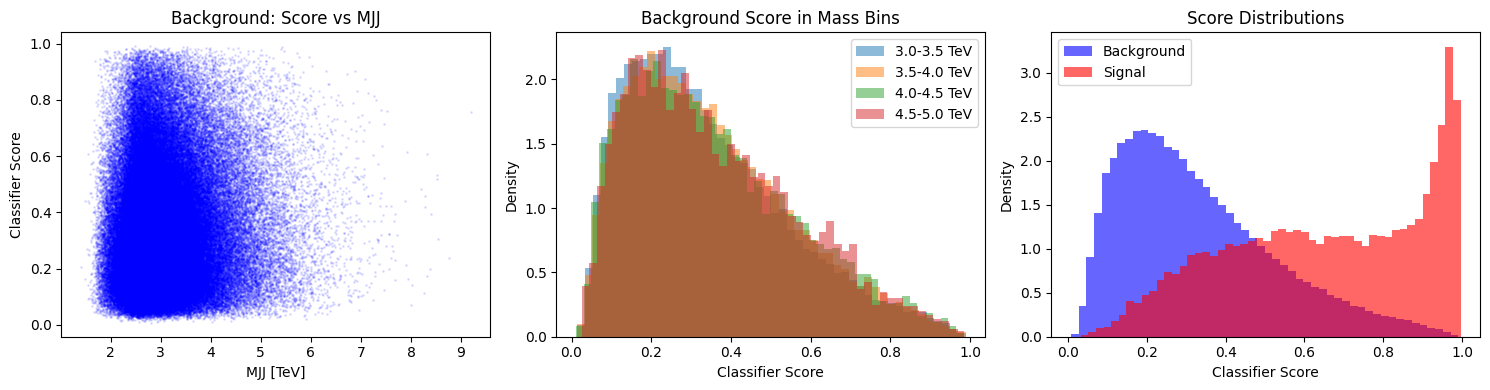

In [36]:
# 1. MASS INDEPENDENCE CHECK
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Background only
bkg_mask = y_test == 0
sig_mask = y_test == 1

# Score vs MJJ for background
ax1 = axes[0]
ax1.scatter(mjj_test[bkg_mask]/1000, y_prob_best[bkg_mask], alpha=0.1, s=1, c='blue')
ax1.set_xlabel('MJJ [TeV]')
ax1.set_ylabel('Classifier Score')
ax1.set_title('Background: Score vs MJJ')

# Score distribution in mass bins (background only)
ax2 = axes[1]
mass_bins = [(3000, 3500), (3500, 4000), (4000, 4500), (4500, 5000)]
for mlow, mhigh in mass_bins:
    mass_cut = (mjj_test >= mlow) & (mjj_test < mhigh) & bkg_mask
    if mass_cut.sum() > 100:
        ax2.hist(y_prob_best[mass_cut], bins=50, alpha=0.5, density=True,
                 label=f'{mlow/1000:.1f}-{mhigh/1000:.1f} TeV')
ax2.set_xlabel('Classifier Score')
ax2.set_ylabel('Density')
ax2.set_title('Background Score in Mass Bins')
ax2.legend()

# Signal vs Background score distribution
ax3 = axes[2]
ax3.hist(y_prob_best[bkg_mask], bins=50, alpha=0.6, density=True, label='Background', color='blue')
ax3.hist(y_prob_best[sig_mask], bins=50, alpha=0.6, density=True, label='Signal', color='red')
ax3.set_xlabel('Classifier Score')
ax3.set_ylabel('Density')
ax3.set_title('Score Distributions')
ax3.legend()

plt.tight_layout()
plt.savefig('/home/asm/LHC-AD/Attempt 5/validation_checks.png', dpi=150)
plt.show()

In [ ]:
# 2. BACKGROUND REJECTION AT FIXED SIGNAL EFFICIENCY
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)

# background rejection at specific signal efficiencies
for target_eff in [0.3, 0.5, 0.7, 0.9]:
    idx = np.argmin(np.abs(tpr - target_eff))
    bkg_rej = 1 / fpr[idx] if fpr[idx] > 0 else float('inf')
    print(f"Signal Eff = {tpr[idx]:.2f} → Background Rejection = 1/{fpr[idx]:.4f} = {bkg_rej:.1f}x")

Signal Eff = 0.30 → Background Rejection = 1/0.0159 = 62.8x
Signal Eff = 0.50 → Background Rejection = 1/0.0713 = 14.0x
Signal Eff = 0.70 → Background Rejection = 1/0.1939 = 5.2x
Signal Eff = 0.90 → Background Rejection = 1/0.4854 = 2.1x


In [ ]:
# 3. CORRELATION CHECK
from scipy.stats import pearsonr

# Background-only correlation between score and mass
corr, pval = pearsonr(mjj_test[bkg_mask], y_prob_best[bkg_mask])
print(f"\nMass-Score Correlation (Background only):")
print(f"  Pearson r = {corr:.4f}, p-value = {pval:.2e}")
if abs(corr) < 0.1:
    print("Good: Low correlation with mass")
else:
    print(" Warning: Significant correlation with mass (potential mass sculpting)")


Mass-Score Correlation (Background only):
  Pearson r = 0.0742, p-value = 6.24e-242
  ✓ Good: Low correlation with mass


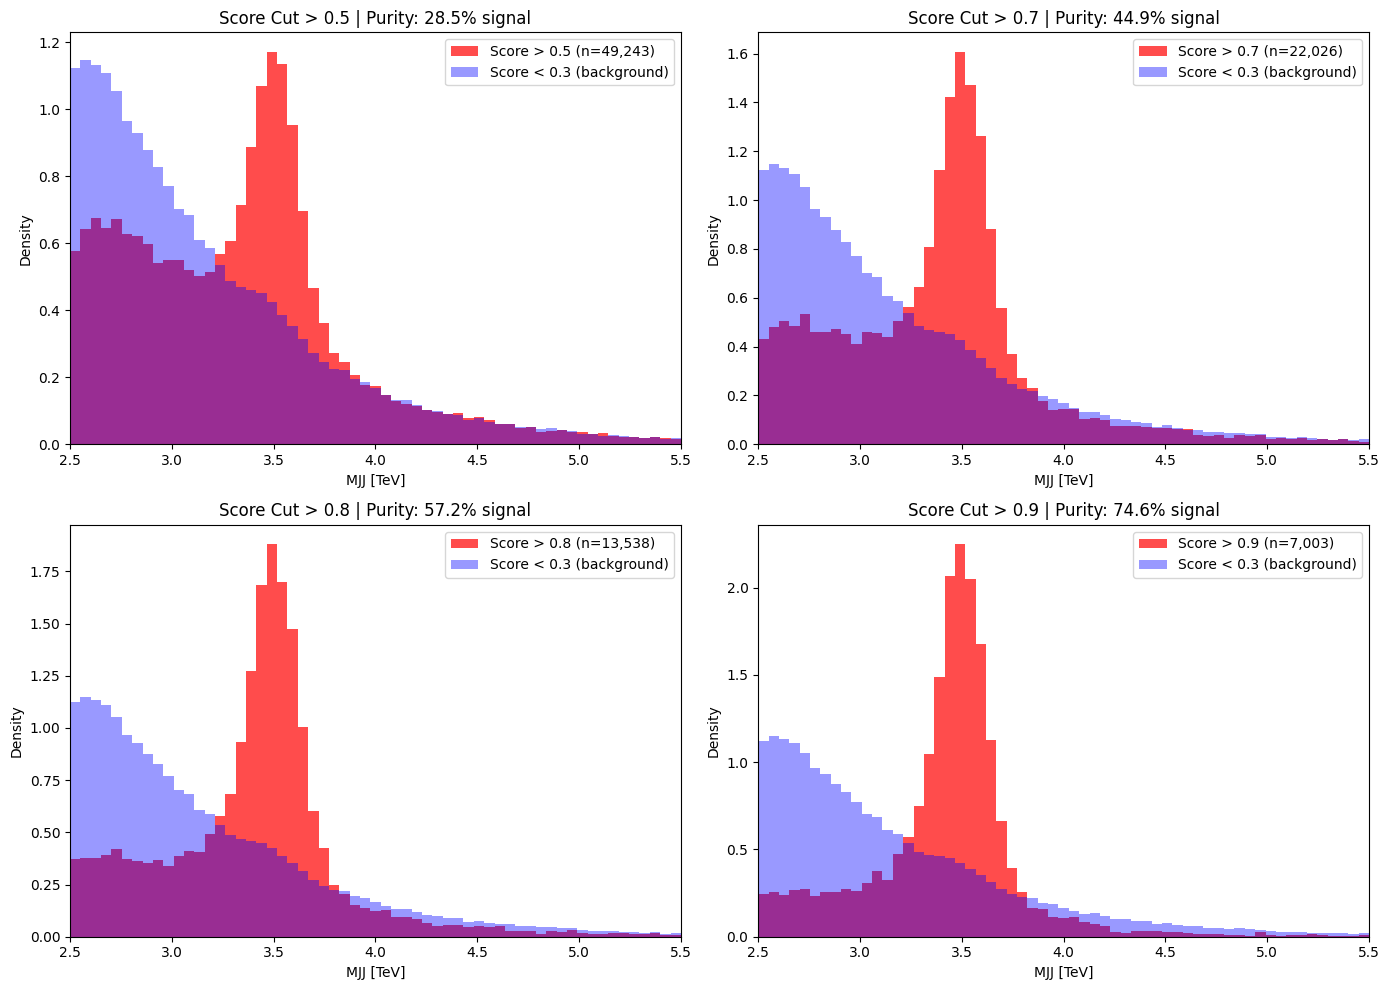

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score cuts to try
score_cuts = [0.5, 0.7, 0.8, 0.9]

# Background-only reference (for bump hunting, we look at low-score events)
bkg_reference = mjj_test[y_prob_tuned < 0.3]

for idx, cut in enumerate(score_cuts):
    ax = axes[idx // 2, idx % 2]
    
    # Events passing the score cut
    pass_cut = y_prob_tuned > cut
    mjj_selected = mjj_test[pass_cut]
    
    # Count signal vs background in selected
    n_sig_selected = (y_test[pass_cut] == 1).sum()
    n_bkg_selected = (y_test[pass_cut] == 0).sum()
    signal_purity = n_sig_selected / len(mjj_selected) if len(mjj_selected) > 0 else 0
    
    # Plot MJJ distribution
    bins = np.linspace(2500, 5500, 60)
    
    ax.hist(mjj_selected/1000, bins=bins/1000, alpha=0.7, 
            label=f'Score > {cut} (n={len(mjj_selected):,})', color='red', density=True)
    ax.hist(bkg_reference/1000, bins=bins/1000, alpha=0.4, 
            label='Score < 0.3 (background)', color='blue', density=True)
    
    ax.set_xlabel('MJJ [TeV]')
    ax.set_ylabel('Density')
    ax.set_title(f'Score Cut > {cut} | Purity: {signal_purity:.1%} signal')
    ax.legend()
    ax.set_xlim(2.5, 5.5)

plt.tight_layout()
plt.savefig('/home/asm/LHC-AD/Attempt 5/resonance_search.png', dpi=150)
plt.show()

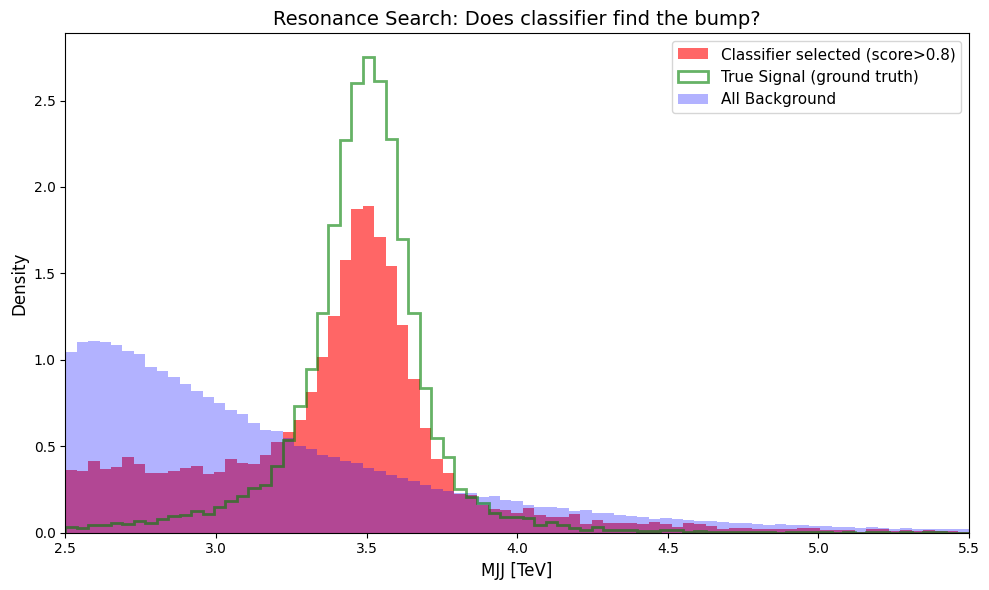


True signal MJJ statistics:
  Mean: 3.48 TeV
  Std:  0.25 TeV
  Peak region: 3.39 - 3.59 TeV


In [ ]:
# Apply tight score cut
score_cut = 0.8
selected = y_prob_tuned > score_cut
mjj_sel = mjj_test[selected]

# True signal in dataset - what's the injected mass?
true_signal_mjj = mjj_test[y_test == 1]

fig, ax = plt.subplots(figsize=(10, 6))

bins = np.linspace(2500, 5500, 80)

# Plot selected events
ax.hist(mjj_sel/1000, bins=bins/1000, alpha=0.6, label=f'Classifier selected (score>{score_cut})', 
        color='red', density=True)

# Plot true signal (ground truth)
ax.hist(true_signal_mjj/1000, bins=bins/1000, alpha=0.6, label='True Signal (ground truth)', 
        color='green', density=True, histtype='step', linewidth=2)

# Plot all background
ax.hist(mjj_test[y_test==0]/1000, bins=bins/1000, alpha=0.3, label='All Background', 
        color='blue', density=True)

ax.set_xlabel('MJJ [TeV]', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Resonance Search: Does classifier find the bump?', fontsize=14)
ax.legend(fontsize=11)
ax.set_xlim(2.5, 5.5)

plt.tight_layout()
plt.savefig('/home/asm/LHC-AD/Attempt 5/resonance_bump.png', dpi=150)
plt.show()

# Print where the true signal peaks
print(f"\nTrue signal MJJ statistics:")
print(f"  Mean: {true_signal_mjj.mean()/1000:.2f} TeV")
print(f"  Std:  {true_signal_mjj.std()/1000:.2f} TeV")
print(f"  Peak region: {np.percentile(true_signal_mjj, 25)/1000:.2f} - {np.percentile(true_signal_mjj, 75)/1000:.2f} TeV")

---
## Summary

This notebook demonstrated:

1. **Training** a 3-channel sparse autoencoder (pT_norm, E, log(pT_norm))
2. **Extracting** 128-dimensional bottleneck features
3. **Classifying** signal vs background using:
   - Logistic Regression
   - Random Forest
   - XGBoost

### Key Architecture:
- Input: 3 channels × 50×50 pixels
- Encoder: 3 → 32 → 64 → 128 channels
- Bottleneck: 128-dim (after global average pooling)
- Classifier: Trained on aggregated bottleneck features

---
## Analysis and Fine tuning


In [ ]:
# Get feature importances from XGBoost
best_model = results['XGBoost']['model']
importances = best_model.feature_importances_
top_indices = np.argsort(importances)[::-1]

print("Top 10 Most Important Bottleneck Channels:")
for i in range(10):
    ch = top_indices[i]
    print(f"  Ch{ch}: importance = {importances[ch]:.4f}")

Top 10 Most Important Bottleneck Channels:
  Ch67: importance = 0.1927
  Ch73: importance = 0.0234
  Ch94: importance = 0.0232
  Ch40: importance = 0.0219
  Ch107: importance = 0.0215
  Ch51: importance = 0.0196
  Ch114: importance = 0.0194
  Ch26: importance = 0.0151
  Ch78: importance = 0.0147
  Ch7: importance = 0.0134


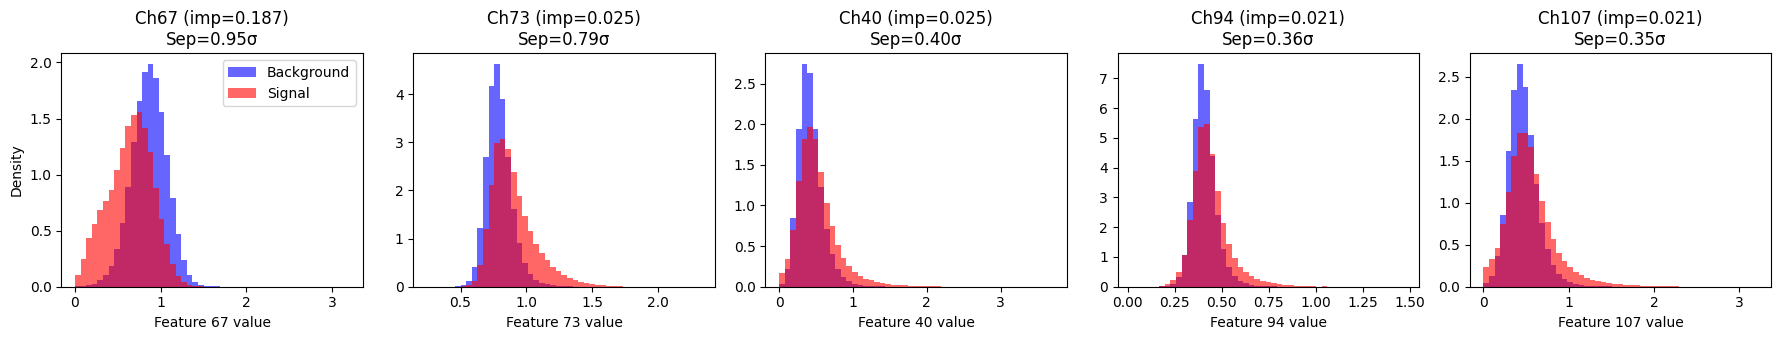

In [ ]:

# Top 5 features to analyze
top_5_channels = top_indices[:5]

fig, axes = plt.subplots(1, 5, figsize=(18, 3.5))

for idx, ch in enumerate(top_5_channels):
    ax = axes[idx]
    
    # Get feature values for signal and background
    feat_bkg = features[labels == 0, ch]
    feat_sig = features[labels == 1, ch]
    
    # Plot distributions
    bins = np.linspace(
        min(feat_bkg.min(), feat_sig.min()),
        max(feat_bkg.max(), feat_sig.max()),
        50
    )
    
    ax.hist(feat_bkg, bins=bins, alpha=0.6, density=True, label='Background', color='blue')
    ax.hist(feat_sig, bins=bins, alpha=0.6, density=True, label='Signal', color='red')
    
    # Calculate separation
    mean_diff = abs(feat_sig.mean() - feat_bkg.mean())
    pooled_std = np.sqrt((feat_sig.std()**2 + feat_bkg.std()**2) / 2)
    separation = mean_diff / pooled_std if pooled_std > 0 else 0
    
    ax.set_title(f'Ch{ch} (imp={importances[ch]:.3f})\nSep={separation:.2f}σ')
    ax.set_xlabel(f'Feature {ch} value')
    if idx == 0:
        ax.set_ylabel('Density')
        ax.legend()

plt.tight_layout()
plt.savefig('/home/asm/LHC-AD/Attempt 5/top_features_analysis.png', dpi=150)
plt.show()

Top   5 features → AUC = 0.7734
Top  10 features → AUC = 0.7894
Top  20 features → AUC = 0.8172
Top  50 features → AUC = 0.8317
Top 100 features → AUC = 0.8358
Top 128 features → AUC = 0.8362


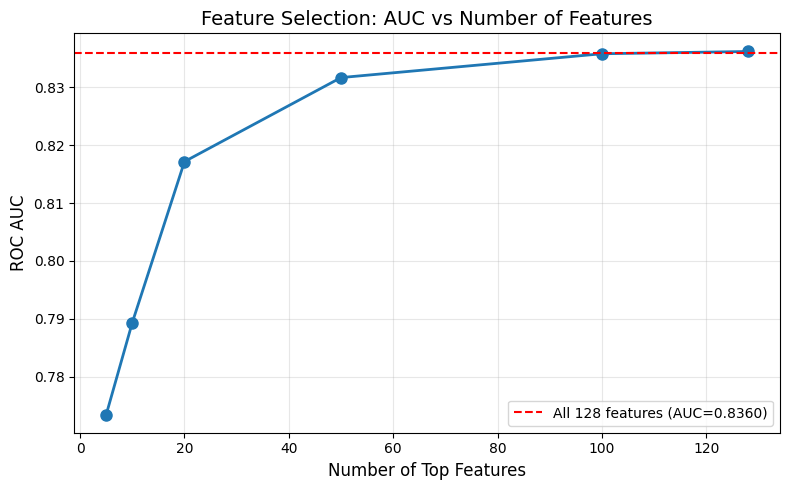

In [ ]:

# Feature Selection: How many features do I actually need?

from sklearn.metrics import roc_auc_score

# Test with different numbers of top features
n_features_to_test = [5, 10, 20, 50, 100, 128]
auc_scores = []

for n_feat in n_features_to_test:
    top_n = top_indices[:n_feat]
    
    # Train XGBoost on subset of features
    X_train_subset = X_train[:, top_n]
    X_test_subset = X_test[:, top_n]
    
    clf_subset = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=10,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
    clf_subset.fit(X_train_subset, y_train)
    
    y_prob_subset = clf_subset.predict_proba(X_test_subset)[:, 1]
    auc = roc_auc_score(y_test, y_prob_subset)
    auc_scores.append(auc)
    
    print(f"Top {n_feat:3d} features → AUC = {auc:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(n_features_to_test, auc_scores, 'o-', markersize=8, linewidth=2)
ax.axhline(y=results['XGBoost']['auc'], color='red', linestyle='--', label=f'All 128 features (AUC={results["XGBoost"]["auc"]:.4f})')
ax.set_xlabel('Number of Top Features', fontsize=12)
ax.set_ylabel('ROC AUC', fontsize=12)
ax.set_title('Feature Selection: AUC vs Number of Features', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('/home/asm/LHC-AD/Attempt 5/feature_selection.png', dpi=150)
plt.show()

In [ ]:

# MANUAL HYPERPARAMETER TUNING 
import gc
tuning_results = {}

# Find best n_estimators
print("Step 1: Testing n_estimators...")
best_n_est = 100
best_auc_n = 0

for n_est in [350, 400, 450, 500]:
    clf = xgb.XGBClassifier(
        n_estimators=n_est, 
        max_depth=6, 
        learning_rate=0.1,
        scale_pos_weight=10, 
        random_state=42, 
        eval_metric='logloss', 
        n_jobs=2
    )
    clf.fit(X_train, y_train)
    auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print(f"  n_estimators={n_est:3d} → AUC={auc:.4f}")
    
    if auc > best_auc_n:
        best_auc_n = auc
        best_n_est = n_est
    
    del clf
    gc.collect()

print(f"\n→ Best n_estimators: {best_n_est} (AUC={best_auc_n:.4f})")
tuning_results['n_estimators'] = best_n_est

Step 1: Testing n_estimators...
  n_estimators=350 → AUC=0.8473
  n_estimators=400 → AUC=0.8477
  n_estimators=450 → AUC=0.8482
  n_estimators=500 → AUC=0.8485

→ Best n_estimators: 500 (AUC=0.8485)


In [ ]:
# Find best max_depth
print("\nStep 2: Testing max_depth...")
best_depth = 6
best_auc_d = 0

for depth in [5, 6, 7]:
    clf = xgb.XGBClassifier(
        n_estimators=best_n_est, 
        max_depth=depth, 
        learning_rate=0.1,
        scale_pos_weight=10, 
        random_state=42, 
        eval_metric='logloss', 
        n_jobs=2
    )
    clf.fit(X_train, y_train)
    auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print(f"  max_depth={depth:2d} → AUC={auc:.4f}")
    
    if auc > best_auc_d:
        best_auc_d = auc
        best_depth = depth
    
    del clf
    gc.collect()

print(f"\n→ Best max_depth: {best_depth} (AUC={best_auc_d:.4f})")
tuning_results['max_depth'] = best_depth


Step 2: Testing max_depth...
  max_depth= 5 → AUC=0.8478
  max_depth= 6 → AUC=0.8485
  max_depth= 7 → AUC=0.8458

→ Best max_depth: 6 (AUC=0.8485)


In [ ]:
# Find best learning_rate
print("\nStep 3: Testing learning_rate...")
best_lr = 0.1
best_auc_lr = 0

for lr in [0.1, 0.12, 0.13]:
    clf = xgb.XGBClassifier(
        n_estimators=best_n_est, 
        max_depth=best_depth, 
        learning_rate=lr,
        scale_pos_weight=10, 
        random_state=42, 
        eval_metric='logloss', 
        n_jobs=2
    )
    clf.fit(X_train, y_train)
    auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print(f"  learning_rate={lr:.2f} → AUC={auc:.4f}")
    
    if auc > best_auc_lr:
        best_auc_lr = auc
        best_lr = lr
    
    del clf
    gc.collect()

print(f"\n→ Best learning_rate: {best_lr} (AUC={best_auc_lr:.4f})")
tuning_results['learning_rate'] = best_lr


Step 3: Testing learning_rate...
  learning_rate=0.10 → AUC=0.8485
  learning_rate=0.12 → AUC=0.8478


KeyboardInterrupt: 

In [ ]:
# Find best subsample
print("\nStep 4: Testing subsample...")
best_sub = 1.0
best_auc_s = 0

for sub in [0.6, 0.7, 0.8, 0.9, 1.0]:
    clf = xgb.XGBClassifier(
        n_estimators=best_n_est, 
        max_depth=best_depth, 
        learning_rate=best_lr,
        subsample=sub,
        scale_pos_weight=10, 
        random_state=42, 
        eval_metric='logloss', 
        n_jobs=2
    )
    clf.fit(X_train, y_train)
    auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print(f"  subsample={sub:.1f} → AUC={auc:.4f}")
    
    if auc > best_auc_s:
        best_auc_s = auc
        best_sub = sub
    
    del clf
    gc.collect()

print(f"\n→ Best subsample: {best_sub} (AUC={best_auc_s:.4f})")
tuning_results['subsample'] = best_sub


Step 4: Testing subsample...
  subsample=0.6 → AUC=0.8477
  subsample=0.7 → AUC=0.8477
  subsample=0.8 → AUC=0.8478
  subsample=0.9 → AUC=0.8478
  subsample=1.0 → AUC=0.8478

→ Best subsample: 0.9 (AUC=0.8478)



FINAL TUNED PARAMETERS:
  n_estimators: 500
  max_depth: 6
Tuned XGBoost AUC:    0.8484


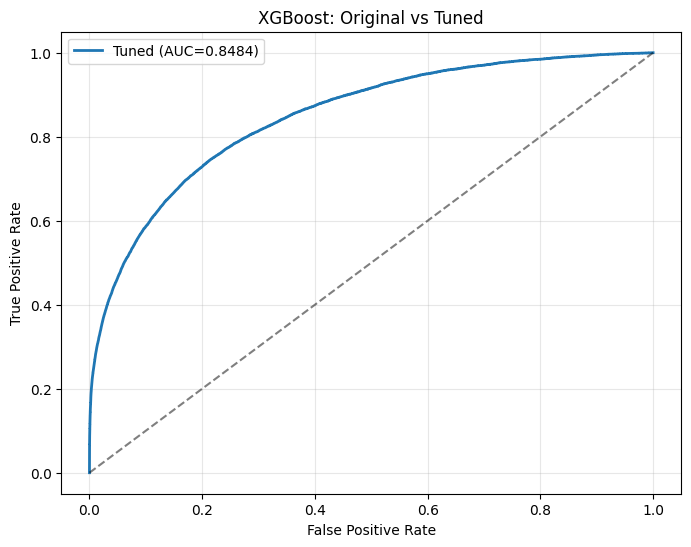

In [ ]:
# FINAL TUNED MODEL
print("FINAL TUNED PARAMETERS:")
print("="*50)
for k, v in tuning_results.items():
    print(f"  {k}: {v}")

# Train final model
final_clf = xgb.XGBClassifier(
    n_estimators=tuning_results['n_estimators'], 
    max_depth=tuning_results['max_depth'], 
    learning_rate=0.1,
    subsample=0.9,
    scale_pos_weight=10, 
    random_state=42, 
    eval_metric='logloss'
)
final_clf.fit(X_train, y_train)

y_prob_tuned = final_clf.predict_proba(X_test)[:, 1]
auc_tuned = roc_auc_score(y_test, y_prob_tuned)

print(f"Tuned XGBoost AUC:    {auc_tuned:.4f}")
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_tuned)

plt.figure(figsize=(8, 6))
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned (AUC={auc_tuned:.4f})', linewidth=2)
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost: Original vs Tuned')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('/home/asm/LHC-AD/Attempt 5/xgb_tuned_comparison.png', dpi=150)
plt.show()

In [ ]:
# SAVE TUNED MODEL
import joblib
import json

# Saving the trained XGBoost model
model_path = '/home/asm/LHC-AD/Attempt 5/Results and wts 3/xgb_tuned_model_2.joblib'
joblib.dump(final_clf, model_path)
print(f"✓ Model saved to: {model_path}")

# Saving the parameters as JSON for reference
params_path = '/home/asm/LHC-AD/Attempt 5/Results and wts 3/xgb_tuned_params_2.json'
params_to_save = {
    'n_estimators': 500,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.9,
    'scale_pos_weight': 10,
    'auc': 0.85
}
with open(params_path, 'w') as f:
    json.dump(params_to_save, f, indent=2)
print(f"Parameters saved to: {params_path}")

# saving the scaler
scaler_path = '/home/asm/LHC-AD/Attempt 5/Results and wts 3/feature_scaler_2.joblib'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

NameError: name 'final_clf' is not defined

In [ ]:
# Loading saved model
import joblib
model = joblib.load('/home/asm/LHC-AD/Attempt 5/xgb_tuned_model.joblib')
scaler = joblib.load('/home/asm/LHC-AD/Attempt 5/feature_scaler.joblib')